###


1D motion --> The motion is restricted in the horizontal or vertical plane


In [1]:
import pickle
import numpy as np
from math import *
import NAFFlib as pnf
import matplotlib.pyplot as plt

In [2]:
params = {'legend.fontsize': 20,
          'figure.figsize': (9.5, 8.5),
          'axes.labelsize': 27,
          'axes.titlesize': 23,
          'xtick.labelsize': 27,
          'ytick.labelsize': 27,
          'image.cmap': 'jet',
          'lines.linewidth': 1,
          'lines.markersize': 5,
          'font.family': 'sans-serif'}

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rcParams.update(params)

#### Simulation parameters

In [3]:
n_turns = 1000
n_particles = 1000
# The following parameters are obtained from the twiss.tfs MAD-X file
beta_x = 29.23897404
beta_y = 76.07315729
alpha_x = -0.8757651182
alpha_y = 1.898525134 
plane_of_study = 'x' # 'V'

In [6]:
path_to_data = '/afs/cern.ch/work/n/natriant/private/sixtracklib_example_crabcavity/output/'
data_file_name = 'tbt_x.pkl'

In [7]:
my_dict = pickle.load( open( path_to_data+data_file_name, 'rb'))

### Tune shift with amplitude
- The tbt data obtained from the simulation are grouped with respect to turns.
- We need to group them in a list for each particle.


(u, pu) <--> (x, px) or (y, py)

In [8]:
u_data = {}
pu_data = {}
for particle in range(n_particles):
    u_data[particle] = []
    pu_data[particle] = []

In [9]:
# maybe even 100 turns are enough
for particle in range(n_particles):
    for turn in range(n_turns):
        u_data[particle].append(my_dict[plane_of_study][turn][particle])
        pu_data[particle].append(my_dict['p'+plane_of_study][turn][particle])

In [10]:
lost_particles = []
Q_list = []

for particle in range(n_particles):
    if np.isnan(u_data[particle]).any() or np.isnan(pu_data[particle]).any():
        lost_particles.append(particle)
        print('particle {} lost'.format(particle))
    else:        
        signal = u_data[particle]
        Q_list.append(pnf.get_tune(np.array(signal)))

### Use normalised coordiantes
\begin{equation}
x_{N} = \frac{x}{\sqrt{\beta(s)}} \\
px_{N} = px \cdot \sqrt{\beta(s)} + x \frac{\alpha(s)}{\sqrt{\beta(s)}}
\end{equation}

Same applies for the vertical plane x <--> y.

### Calculate initial actions Jx
\begin{equation}
J_x = \frac{x_{N}^2 + px_{N}^2}{2} 
\end{equation}

Same applies for the vertical plane x <--> y.

In [11]:
flag_initial_actions = True
if flag_initial_actions :
    if plane_of_study == 'x':
        beta = beta_x
        alpha = alpha_x
    else:
        beta = beta_y
        alpha = alpha_y
        
    u_norm = my_dict[plane_of_study][0]/sqrt(beta) # the index 0 corresponds to turn
    pu_norm = my_dict['p'+plane_of_study][0]*sqrt(beta) + my_dict[plane_of_study][0]*alpha/sqrt(beta)
    
    
    J_initial = (u_norm**2 + pu_norm**2)
    print('J{}_min= {}, J{}_max={}'.format(plane_of_study, min(J_initial), plane_of_study, max(J_initial)))

Jx_min= 9.712991013083473e-12, Jx_max=9.34406069474299e-08


### Plot the detuning with amplitude

<IPython.core.display.Javascript object>


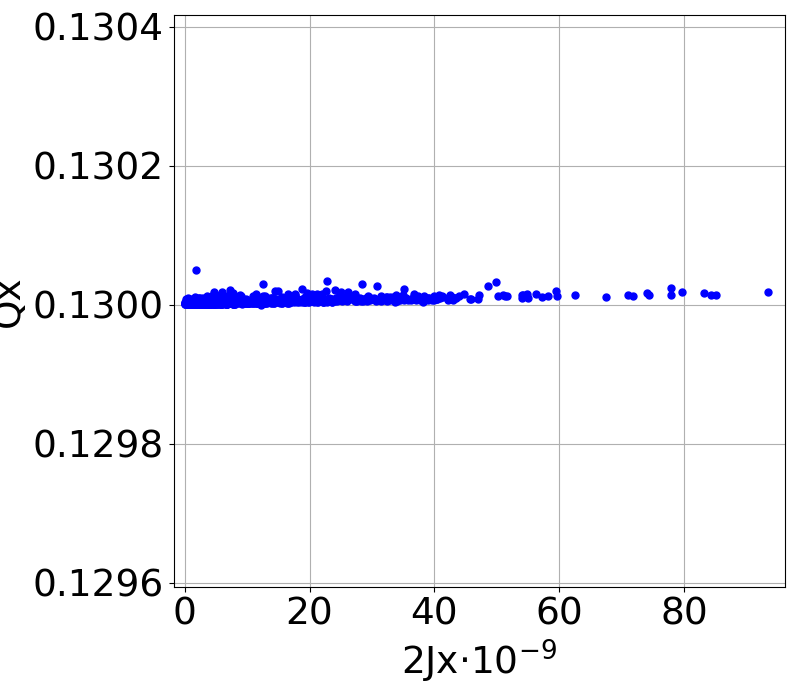

0.13004947311477696


In [13]:
%matplotlib notebook
fig, ax = plt.subplots(1,1,figsize=(8,7))
print(max(Q_list))
ax.plot(np.array(J_initial)*1e9, Q_list, 'o', c='b') # the index 0 corresponds to turn
ax.set_xlabel('2J{}'.format(plane_of_study) + r'$\cdot 10^{-9}$')
ax.set_ylabel('Q{}'.format(plane_of_study))
ax.set_ylim(0.125,0.135)
plt.tight_layout()
plt.grid()

savefig = False
if savefig:
    plt.savefig('tune_shift_v2.png')